<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Actividad 1. Limpieza de un Dataset.</header1></centre>

<center>JUAN DAVID ESCOBAR ESCOBAR</center>
<center>Diciembre 2021</center>

## Fase 0.  Inicialización y configuración

### 0. Inicializar pySpark e Imporatar librerias

In [25]:
import os
import chardet
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

os.getcwd()

'/Users/juandavidescobarescobar/Documents/Unir/Materias/BD Big Data/Actividad 1'

In [26]:
#testing pyspark installation
import findspark
findspark.init('/Users/juandavidescobarescobar/Documents/Apache Spark/spark-3.2.0-bin-hadoop3.2')
findspark.find()
import pyspark
findspark.find()

'/Users/juandavidescobarescobar/Documents/Apache Spark/spark-3.2.0-bin-hadoop3.2'

In [27]:
#Libs Spark Context

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DateType
from pyspark.sql import functions as f
from pyspark.sql.functions import trim

In [28]:
#Init Spark Context

conf = pyspark.SparkConf().setAppName('SparkApp').setMaster('local')
sc = pyspark.SparkContext(conf = conf)
spark = SparkSession(sc)
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/13 18:56:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


DataFrame[key: string, value: string]

## Fase 1. Interpretación de datos crudos (Raw Zone)

### Definición funciones de validacion - CSV

In [ ]:
'''
En esta parte del código se encarga de validar la lectura correcta del archivo en formato CSV, de acuerdo
a sus propiedades (encabezados, encoding, separador de línea, separador de columna, filas, columnas) 
y el esquema o tipología de los datos.
''' 

In [30]:
"""
Descripción: Retorna boolean que determina si el archivo cuenta con el encoding UTF-8.
Responsables: Juan David Escobar E
Fecha: 30/11/2021
"""

def is_valid_encoding_csv(ar_file):
    this_encoding = 'UTF-8'
    result = chardet.detect(open(ar_file, 'rb').read())
    charenc = result['encoding']
    return  True if this_encoding in charenc.upper() else False

In [31]:
"""
Descripción: Retorna una lista con los registros que no cumplen
             con el patrón de texto o expresión regular parametrizada
             para una columna.
Responsables: Juan David Escobar E
Fecha: 05/12/2021
"""

def is_valid_txt_regrex(reg, col_pattern, col_pk):

    col_pattern_reg = col_pattern + '_reg'

    df = df.withColumn(col_pattern_reg, f.col(col_pattern)\
           .rlike(reg))
    lst_bad_records = df.filter(f.col(col_pattern_reg) == False)\
                        .select(col_pk, col_pattern_reg)\
                        .collect()

    return lst_bad_records

In [32]:
"""
Descripción: Valida el formato de los valores de campos tipo timestamp.
Return: 
    List con los bad records
Responsables: Juan David Escobar E
Fecha: 05/12/2021.

Ejecucion: validate_format_timestamp('10/02/1991 01:30')
"""

def validate_format_timestamp(df, col_timestamp, col_format = "dd/mm/yy HH:mm"):
    df2 = df.withColumn("badRecords",\
                         f.when(f.to_timestamp(f.col(col_timestamp), col_format)\
                         .cast("Timestamp")\
                         .isNull() & \
                         f.col(col_timestamp)\
                         .isNotNull(),\
                         f.lit("Not a valid Timestamp"))\
                         .otherwise(f.lit(None))
                         )
    list_bad_rows = df2.filter((f.col("badRecords").isNotNull()) & (f.col("badRecords") == "Not a valid Timestamp")).collect()
       
    return list_bad_rows

In [33]:
"""
Descripción: Retorna los registros duplicados a partir de un Dataframe, y los registros unicos
Parámetros:
    ar_file -- Archivo a validar
    gb_records -- String el cual contiene los nombres de la columna que son unicos del Dataframe.
Responsables: Juan David Escobar E
Fecha: 01/12/2021
"""

def get_duplicates(df_csv, df_pk):
    is_error = False
    msg_error = ''
    separator = ''
    result_dic = {'is_error' : '', 'msg_error' : ''}
       
    try: 
        df_Campo = df_csv.groupby(df_pk).count()
        df_duplicados = df_Campo.select(f.col(df_pk), f.col("count")).filter(f.col("count") > 1).collect()
        duplicados = [str(df_pk + ": " + str(row[df_pk]) + " - Cantidad: " + str(row['count'])) for row in df_duplicados]
                
        if len(duplicados) > 0:
            
            for i in range(len(duplicados)):
                lista_duplicados = duplicados[i].split(",")
                msg_error += separator + "["+(lista_duplicados[0].replace('"',''))+"]"
                separator = ', '

            is_error = True           
            result_dic = {'is_error' : is_error, 'msg_error' : msg_error}
            
    except Exception as error:
        is_error = False
        msg_error = 'No se pudo validar duplicados. !ERROR¡: ' + str(error)
        result_dic = {'is_error' : is_error, 'msg_error' : msg_error}
    return result_dic

In [34]:
'''
Descripción: Lectura desde una ruta local un archivo en formato CSV, el cual se  intenta interpreta 
             interpretar por primera vez, asumiendo que el archivo posee un encoding tipo UTF-8, no 
             se especifica esquema, delimitador el caracter ";", salto de linea el caracter CRLF y 
             la primera fila con encabezado.
Responsables: Juan David Escobar E
Fecha: 30/11/2021
'''

def read_csv():

    # File location (https://www.youtube.com/watch?v=-tZbkgTnGs4)
    file_location = '/Users/juandavidescobarescobar/Documents/Unir/Materias/BD Big Data/Actividad 1/data_act_03.csv'
    file_type = 'csv'

    # CSV options
    infer_schema = 'true'
    first_row_is_header = 'true'
    delimiter = ';'
    
    # Validate encoding UTF-8
    is_valid_encode = is_valid_encoding_csv(file_location)
    
    if is_valid_encode:
                
        try:        
            # The applied options are for CSV files. For other types, these will ignored.
            df = spark.read.format(file_type) \
                           .option('inferSchema', infer_schema) \
                           .option('header', first_row_is_header) \
                           .option('sep', delimiter) \
                           .load(file_location) 
        except Exception as error:
                        
            print('Error leyendo el archivo: ' + str(error))
                
    return df    

### Lectura y limpieza 

In [35]:
# Init clean and file validations

# 1. Comparar el esquema inferido por pySpark Dataframe vs Los valores almacenados en el archivo

df = read_csv()
df.limit(20).toPandas().head()

,CrimeId,OriginalCrimeTypeName,OffenseDate,CallTime,CallDateTime,Disposition,Address,City,State,AgencyId,Range,AddressType
0,160903280,Assault / Battery,2016-03-30T00:00:00,18:42,2016-03-30T18:42:00,REP,100 Block Of Chilton Av,San Francisco,CA,1,None,Premise Address
1,160912272,Homeless Complaint,2016-03-31T00:00:00,15:31,2016-03-31T15:31:00,GOA,2300 Block Of Market St,San Francisco,CA,1,None,Premise Address
2,160912590,Susp Info,2016-03-31T00:00:00,16:49,2016-03-31T16:49:00,GOA,2300 Block Of Market St,San Francisco,CA,1,None,Premise Address
3,160912801,Report,2016-03-31T00:00:00,17:38,2016-03-31T17:38:00,GOA,500 Block Of 7th St,San Francisco,CA,1,None,Premise Address
4,160912811,594,2016-03-31T00:00:00,17:42,2016-03-31T17:42:00,REP,Beale St/bryant St,San Francisco,CA,1,None,Intersection


### Descripción y analisis de los datos

In [36]:
df_pd = df.toPandas()
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10051 entries, 0 to 10050
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CrimeId                10051 non-null  int32 
 1   OriginalCrimeTypeName  10051 non-null  object
 2   OffenseDate            10051 non-null  object
 3   CallTime               10051 non-null  object
 4   CallDateTime           10051 non-null  object
 5   Disposition            10051 non-null  object
 6   Address                10051 non-null  object
 7   City                   9730 non-null   object
 8   State                  10048 non-null  object
 9   AgencyId               10051 non-null  object
 10  Range                  0 non-null      object
 11  AddressType            10051 non-null  object
dtypes: int32(1), object(11)
memory usage: 903.1+ KB


In [37]:
#df.printSchema()
df_pd.describe(include='all')

,CrimeId,OriginalCrimeTypeName,OffenseDate,CallTime,CallDateTime,Disposition,Address,City,State,AgencyId,Range,AddressType
count,1.005100e+04,10051,10051,10051,10051,10051,10051,9730,10048,10051,0,10051
unique,NaN,575,9,1416,5116,19,5387,8,1,2,0,6
top,NaN,Traffic Stop,2016-04-02T00:00:00,17:39,2016-04-04T12:23:00,HAN,900 Block Of Market St,San Francisco,CA,1,NaN,Premise Address
freq,NaN,1215,2259,19,8,2820,58,9665,10048,10048,NaN,5059
mean,1.609394e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.327006e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.609033e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.609303e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.609408e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.609513e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Descripción de datos numericos por medio de graficos 


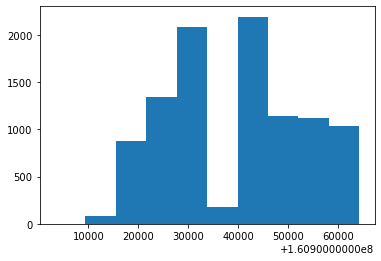

In [38]:
''' 
Generamos los histogramas de dos variables numéricas que presenta 
la tabla de datos: CrimeId y a AgencyId
'''

data_crime_id = list(df_pd["CrimeId"])

plt.hist(data_crime_id, 10)
plt.show()

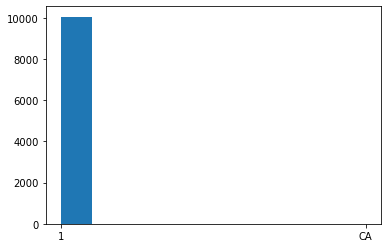

In [39]:
''' 
Generamos los histogramas de dos variables numéricas que presenta 
la tabla de datos: CrimeId y a AgencyId
'''

data_agency_id = list(df_pd["AgencyId"])

plt.hist(data_agency_id, 10)
plt.show()

### Descripción manual por cada columna

In [ ]:
# -- CrimeId: integer (nullable = true), El tipo de dato corresponde al que se infiere en el esquema, al ser un
#             identificador de registro este campo no debería aceptar valores nulos, por lo cual se debe
#             corregir en el esquema inferido de manera automatica por Spark Dataframe.
          
# -- OriginalCrimeTypeName: string (nullable = true), Los valores concuerdan con el tipo de dato inferido "String", 
#                           el cual acepta valores nulos sin ningun inconveniente, a simple vista en el archivo se
#                           logra identificar algunos patrones de información numerica como por ejemplo "594" o 
#                           caracteres sin sentido o en código "lp" que no concuerdan con la descripción o proposito del 
#                           campo, se puede concluir que son datos errados que quiza debamos limpiar del dataset, teniendo
#                           muy presente la previa autorización y validación del analista de negocio a cargo.

# -- OffenseDate: timestamp (nullable = true),  Formato de la fecha:YYYY-MM-DD T HH:MM:SS, para que este formato
#                 identificado a ojo en el archivo CSV cumpla su estructura, se debe generar en una segunda 
#                 lectura del dataset leído o inferido de manera original, a un nuevo dataset donde se especifique 
#                 el formato que predomina para la fecha y tipo de dato inferido de manera automatica, por medio de
#                 un constrain en un nuevo schema definido por el usuario. Adicional a esto se puede intentar hacer un 
#                 casteo de este formato para todos los valores del dataset e identificar valores con error, aunque si
#                 el esquema que lo inferio de manera automatica tiene un tipo de dato timestamp, esto nos da la tranquilidad 
#                 de sasber que los valorers estan correctos para este formato de estampa de tiempo.

# -- CallTime: string (nullable = true) Formato HH:MM, el tipo de dato se infirio de tipo texto, pero identificamos 
#              un factor que se relaciona con la descripción o nombre del campo, para asegurarnos que todos los valores 
#              cumplan con este formato, es importante validarlo por medio de una expresión regular, excluyendo 
#              aquellos valores nulos. Otra manera es recrear el dataset con un esquema especificado en el cual
#              asignemos este tipo de dato como timestamp con el formato HH:MM.

# -- CallDateTime: timestamp (nullable = true), Aplica la misma descripción que se especifico para el campo 
#                  "OffenseDate"
                 
# -- Disposition: string (nullable = true), Los valores concuerdan con el tipo de dato inferido "String", tambien 
#                 se analiza la longitud de los caracteres de cada campo, la cual es de 3 y en mayuscula, ejemplo "REP".
#                 A simple vista se detectan algunos campos vacios, lo cual es normal, pero se detectan valores que no 
#                 cumplen el mismo patron 3 caracteres en letra mayuscula, se identifican valores como por ejemplo:
#                 "Not recorded", lo cual se puede asumir que es un Dummy que se almaceno ya que no se disponia el 
#                 valor, en este caso lo mejor es limpiar esta información para dejar la información mas consistente.

# -- Address: string (nullable = true), Los valores concuerdan con el tipo de dato inferido "String", lo cual es un
#             buen indicio ya que es el tipo de dato comunmente usado para las direcciones en la mayoría de sistemas
#             de información, ya que almacenan valores alfanumericos. No se identifican valores atipicos. 

# -- City: string (nullable = true), Los valores concuerdan con el tipo de dato inferido "String", lo cual es un
#             buen indicio ya que es el tipo de dato comunmente usado para las ciudades, los valores tienen la descipcion
#             completa de una sola ciudad la cual es San Francisco, algunos campos tienen valores nulos, los cuales
#             se deben dejar tal cual ya que no se posee información de cual ciudad del estado CA: California pueden
#             pertenecer Ej: (Los Angeles, San Francisco, San Jose, entre otros). El factor común es San Francisco, pero
#             lo correcto sería reportar estos campos a los dueños de la informacón para corregirlos en una carga posterior
#             y actualizarlos por el ID.

# -- State: string (nullable = true) CA 2 CHARACTERS, Los valores concuerdan con el tipo de dato inferido "String", lo cual
#           es un buen indicio ya que es el tipo de dato comunmente usado para las estados, 
#           https://es.wikipedia.org/wiki/Anexo:Abreviaciones_de_los_estados_de_Estados_Unidos. Para validar la calidad
#           de la información se puede hacer un distinc de la información para conocer las diferentes categorias
#           registradas, y se debe validar que cumplen el formato de 2 caracteres en mayúsculas.

# -- AgencyId: string (nullable = true) INT, Los valores no concuerdan con el tipo de dato inferido, ya que 
#              debería ser un INT, esta columna no es relevante en esta sabana de datos ya que es solo el
#              Id numerico de la agencia donde se reporto el crimen, pero que no brinda una descripción, quiza
#              este dato se deba conservar para poder relacionar esta tabla de registro de crimenes con otro
#              dataset de agencias.

# -- Range: string (nullable = true) Los valores no concuerdan con la descriopcion del campo, ya que normalmente
#           un rango es un tipo de dato entero, pero que tambien puede ser la descripcion de un limite inferior y
#           superior, en este caso esta columna no tiene valores y no proporciona información asociada al crimen ya que
#           todos los valores son null.
          
# -- AddressType: string (nullable = true), Los valores concuerdan con el tipo de dato inferido "String", para validar
#                 la calidad de la información se puede hacer un distinct de las categorias o tipos de dirección
#                 y validar cual de ellas es un dato errado que no pertenece a un tipo de dirección.

## Fase 2. Datos procesados (Processed Zone) 

### Validar y eliminar registros duplicados

In [40]:
# Validar cantidad de valores duplicados en cada variable

for column in df_pd:
    
    current_lst = df_pd[column].unique()
    current_lst = list(filter(None, current_lst))
    
    print('{0},  Valores Unicos {1}'.format(column, len(current_lst)))
    #print('{0},  Valores Unicos {1}'.format(column, df_pd[column].unique()))   

CrimeId,  Valores Unicos 10047
OriginalCrimeTypeName,  Valores Unicos 575
OffenseDate,  Valores Unicos 9
CallTime,  Valores Unicos 1416
CallDateTime,  Valores Unicos 5116
Disposition,  Valores Unicos 19
Address,  Valores Unicos 5387
City,  Valores Unicos 8
State,  Valores Unicos 1
AgencyId,  Valores Unicos 2
Range,  Valores Unicos 0
AddressType,  Valores Unicos 6


In [41]:
# 7. Limpieza general - Elimina las filas duplicadas - por todos los campos

df = df.drop_duplicates()
df.count()

10051

### Identificar tipos de datos, patrones y formatos

In [ ]:
# |-- CrimeId: integer (nullable = true)
# |-- OriginalCrimeTypeName: string (nullable = true)
# |-- OffenseDate: timestamp (nullable = true)  YYYY-MM-DD T HH:MM:SS
# |-- CallTime: string (nullable = true) HH:MM
# |-- CallDateTime: timestamp (nullable = true) YYYY-MM-DD T HH:MM:SS
# |-- Disposition: string (nullable = true) 3 charascter MAX EX: REP
# |-- Address: string (nullable = true) 
# |-- City: string (nullable = true)
# |-- State: string (nullable = true) CA 2 CHARACTERS
# |-- AgencyId: string (nullable = true) INT (OJO ERROR)
# |-- Range: string (nullable = true) INT?? OJO SIN DATOS
# |-- AddressType: string (nullable = true) String

### Identificar y analizar posible eliminación filas duplicadas por llave primaria

In [42]:

df_pd["CrimeId"].value_counts() #10047 uniques

#df_pd["CrimeId"].drop_duplicates()

160950496    3
160913455    3
160943740    1
160943710    1
160943712    1
            ..
160931823    1
160931824    1
160931825    1
160931827    1
160964249    1
Name: CrimeId, Length: 10047, dtype: int64

In [43]:
# 8. Limpieza general - Elimina las filas duplicadas - por "CrimeId"

df_pk = 'CrimeId'
list_duplicates = get_duplicates(df, df_pk)
print(list_duplicates)

# '''
# No se elimina ya que el ID tiene valores diferentes para
# cada valor en la columna repetido

# if result_duplicates['is_error']:
#     #df.drop_duplicates(subset = [df_pk])
#     print('Identificadores duplicados: {0}'.format(result_duplicates))
#     '''

{'is_error': True, 'msg_error': '[CrimeId: 160950496 - Cantidad: 3], [CrimeId: 160913455 - Cantidad: 3]'}


In [44]:
df2 = df.filter(f.col("Crimeid") == '160950496')

df2.limit(20).toPandas().head()

,CrimeId,OriginalCrimeTypeName,OffenseDate,CallTime,CallDateTime,Disposition,Address,City,State,AgencyId,Range,AddressType
0,160950496,Trespasser,2016-04-04T00:00:00,6:51,2016-04-04T06:51:00,CAN,Block Of Hampshire St,San Francisco,CA,1,None,Premise Address
1,160950496,Passing Call,2016-04-04T00:00:00,6:51,2016-04-04T06:51:00,HAN,University St/felton St,San Francisco,CA,1,None,Intersection
2,160950496,Suspicious Vehicle,2016-04-04T00:00:00,6:51,2016-04-04T06:51:00,ND,1400 Block Of Cabrillo St,San Francisco,CA,1,None,Premise Address


In [45]:
df2 = df.filter(f.col("Crimeid").isNull())

df2.limit(20).toPandas().head()

,CrimeId,OriginalCrimeTypeName,OffenseDate,CallTime,CallDateTime,Disposition,Address,City,State,AgencyId,Range,AddressType


### Validar formatos de fecha y tiempo

In [46]:
# Validar formato fechas

list_bad_rec_offense_date = validate_format_timestamp(df, "OffenseDate", col_format = "yyyy-mm-dd")
list_bad_rec_call_time = validate_format_timestamp(df, "CallTime", col_format = "HH:mm")
list_bad_rec_call_date_time = validate_format_timestamp(df, "CallDateTime", col_format = "yyyy-MM-dd'T'HH:mm:ss")

print('list_bad_rec_offense_date: ', list_bad_rec_offense_date) 
print('list_bad_rec_call_time: ', list_bad_rec_call_time)
print('list_bad_rec_call_date_time: ', list_bad_rec_call_date_time)

list_bad_rec_offense_date:  []
list_bad_rec_call_time:  []
list_bad_rec_call_date_time:  []


### Eliminar columnas con información redundate

In [47]:
# Eliminación de variables redundantes y sin información

columns_to_drop = ['OffenseDate', 'CallTime', 'Range']
df = df.drop(*columns_to_drop)
df.limit(20).toPandas().head()

,CrimeId,OriginalCrimeTypeName,CallDateTime,Disposition,Address,City,State,AgencyId,AddressType
0,160913997,Pay,2016-03-31T23:51:00,ABA,1600 Block Of Green St,San Francisco,CA,1,Premise Address
1,160920463,Well Being Check,2016-04-01T05:49:00,ND,Ada Ct/ofarrell St,San Francisco,CA,1,Intersection
2,160920488,Encampent,2016-04-01T06:15:00,ADV,500 Block Of Florida St,San Francisco,CA,1,Premise Address
3,160920709,Suspicious Vehicle,2016-04-01T08:00:00,HAN,Granada Av/holloway Av,San Francisco,CA,1,Intersection
4,160920723,Traffic Stop,2016-04-01T08:05:00,CIT,7th St/mission St,San Francisco,CA,1,Intersection


### Validar formatos de texto estandarizados para texto (Expresiones regulares)

In [48]:
# Validar formatos estandarizados de texto (Disposition, State)

col_pk = 'CrimeId'
reg = r'^[A-Z]{3}'               # r'^[A-Z]{3}' , r'^[A-Z]{2}'
col_pattern = 'Disposition'       #'Disposition', 'State'  
col_pattern_reg = col_pattern + '_reg'

df_formats = df.withColumn(col_pattern_reg, f.col(col_pattern).rlike(reg))
df_formats = df_formats.filter(f.col(col_pattern_reg) == False)
df_formats = df_formats.select(col_pk, col_pattern, col_pattern_reg)
        
#print(lst)
df.limit(20).toPandas().head()

,CrimeId,OriginalCrimeTypeName,CallDateTime,Disposition,Address,City,State,AgencyId,AddressType
0,160913997,Pay,2016-03-31T23:51:00,ABA,1600 Block Of Green St,San Francisco,CA,1,Premise Address
1,160920463,Well Being Check,2016-04-01T05:49:00,ND,Ada Ct/ofarrell St,San Francisco,CA,1,Intersection
2,160920488,Encampent,2016-04-01T06:15:00,ADV,500 Block Of Florida St,San Francisco,CA,1,Premise Address
3,160920709,Suspicious Vehicle,2016-04-01T08:00:00,HAN,Granada Av/holloway Av,San Francisco,CA,1,Intersection
4,160920723,Traffic Stop,2016-04-01T08:05:00,CIT,7th St/mission St,San Francisco,CA,1,Intersection


### Estandarizar valores tipo texto (Mayúsculas, sin espacios y homologados)

In [54]:
# Eliminación de espacios en blancos para las variables tipo texto
# [OriginalCrimeTypeName, Disposition, Address, City, State y Range] 
# Estandarizacion de la los datos en Mayusculas
from pyspark.sql.functions import *

list_cols_str = [item[0] for item in df.dtypes if item[1].startswith('string')]

for col_name in list_cols_str:
    df = df.withColumn(col_name, upper(trim(f.col(col_name))))

df.limit(20).toPandas().head()

['OriginalCrimeTypeName', 'CallDateTime', 'Disposition', 'Address', 'City', 'State', 'AgencyId', 'AddressType']


,CrimeId,OriginalCrimeTypeName,CallDateTime,Disposition,Address,City,State,AgencyId,AddressType
0,160913997,PAY,2016-03-31T23:51:00,ABA,1600 BLOCK OF GREEN ST,SAN FRANCISCO,CA,1,PREMISE ADDRESS
1,160920463,WELL BEING CHECK,2016-04-01T05:49:00,ND,ADA CT/OFARRELL ST,SAN FRANCISCO,CA,1,INTERSECTION
2,160920488,ENCAMPENT,2016-04-01T06:15:00,ADV,500 BLOCK OF FLORIDA ST,SAN FRANCISCO,CA,1,PREMISE ADDRESS
3,160920709,SUSPICIOUS VEHICLE,2016-04-01T08:00:00,HAN,GRANADA AV/HOLLOWAY AV,SAN FRANCISCO,CA,1,INTERSECTION
4,160920723,TRAFFIC STOP,2016-04-01T08:05:00,CIT,7TH ST/MISSION ST,SAN FRANCISCO,CA,1,INTERSECTION


### Tratamiento y validación de Null Values (Variables númericas)

In [55]:
import pyspark.sql.functions as F
def count_missings(spark_df, sort = True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

count_missings(df)

,count
City,321
State,3
CrimeId,0
OriginalCrimeTypeName,0
CallDateTime,0
Disposition,0
Address,0
AgencyId,0
AddressType,0


In [ ]:
# Calculo del valor medio sin tener encuneta los valores Nan, 
# este paso solo aplica para variables tipo númericas, aplica
# cuando tenego valores nulos en una muestra menor al 50% para rellenar

'''
from pyspark.sql.functions import mean as _mean, stddev as _stddev

col_name = 'colName'

df_stats = df.select(
    _mean(f.col(col_name)).alias('mean'),
    _stddev(f.col(col_name)).alias('std')
).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']

print(mean, std)
'''

In [56]:
# Eliminar filas NULL

df = df.na.drop()

# Rellenar valores NULL con comodin -99, solo para variables
# categoricas que son las que cuentan con valores NULL

df.na.fill("-99").show()

df_pd = df.toPandas()
df_pd.info()

+---------+---------------------+-------------------+------------+--------------------+-------------+-----+--------+---------------+
|  CrimeId|OriginalCrimeTypeName|       CallDateTime| Disposition|             Address|         City|State|AgencyId|    AddressType|
+---------+---------------------+-------------------+------------+--------------------+-------------+-----+--------+---------------+
|160913997|                  PAY|2016-03-31T23:51:00|         ABA|1600 BLOCK OF GRE...|SAN FRANCISCO|   CA|       1|PREMISE ADDRESS|
|160920463|     WELL BEING CHECK|2016-04-01T05:49:00|          ND|  ADA CT/OFARRELL ST|SAN FRANCISCO|   CA|       1|   INTERSECTION|
|160920488|            ENCAMPENT|2016-04-01T06:15:00|         ADV|500 BLOCK OF FLOR...|SAN FRANCISCO|   CA|       1|PREMISE ADDRESS|
|160920709|   SUSPICIOUS VEHICLE|2016-04-01T08:00:00|         HAN|GRANADA AV/HOLLOW...|SAN FRANCISCO|   CA|       1|   INTERSECTION|
|160920723|         TRAFFIC STOP|2016-04-01T08:05:00|         CIT|   

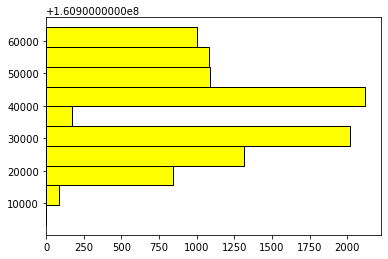

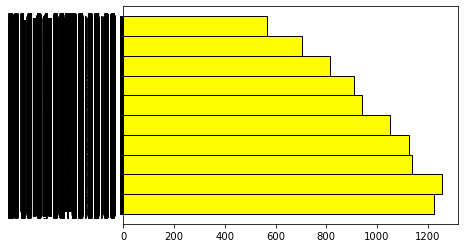

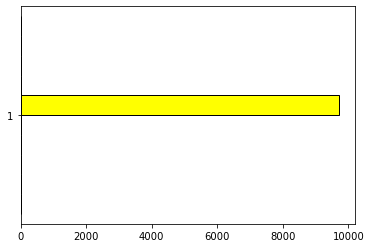

In [57]:
# Validación de datos atipicos - Variables Numericas

def draw_hist_num_vars(list_var_num):
    
    for col_nm in list_var_num:
        
        list_data_col = df.select(col_nm).rdd.flatMap(lambda x: x).collect()
        plt.hist(list_data_col, 
                 color="yellow",
                 ec="black", 
                 orientation ='horizontal')
        
        plt.show()

list_var_num = ['CrimeId','CallDateTime', 'AgencyId']    
draw_hist_num_vars(list_var_num)

In [65]:
from pyspark.sql.functions import *

df = df.withColumn("AgencyId", f.col("AgencyId").cast(IntegerType()))

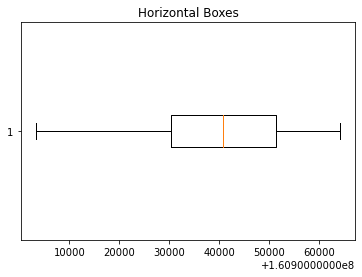

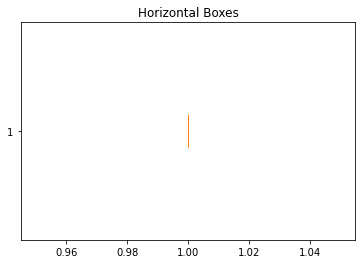

In [67]:
# Grafico de bigotes, distribución de los datos
# para analizar los datos de la variable fecha
# se debe convertir en un numero entero

def draw_bigotes_num_vars(list_var_num):
    
    for col_nm in list_var_num:
        
        list_data_col = df.select(col_nm)\
                          .rdd.flatMap(lambda x: x)\
                          .collect()
        red_square = dict(markerfacecolor='r', marker='s')
        fig5, ax5 = plt.subplots()
        ax5.set_title('Horizontal Boxes')
        ax5.boxplot(list_data_col,
                    vert=False,
                    flierprops=red_square)
        
        plt.show()

list_var_num = ['CrimeId', 'AgencyId']  
draw_bigotes_num_vars(list_var_num)

/Users/juandavidescobarescobar/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


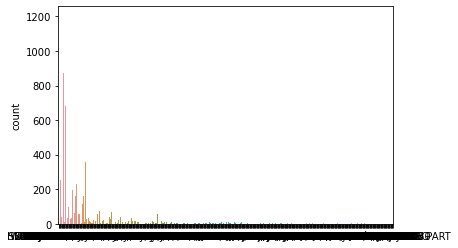

/Users/juandavidescobarescobar/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


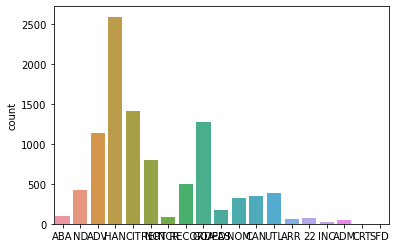

/Users/juandavidescobarescobar/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


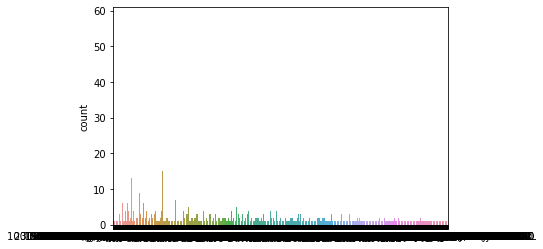

/Users/juandavidescobarescobar/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


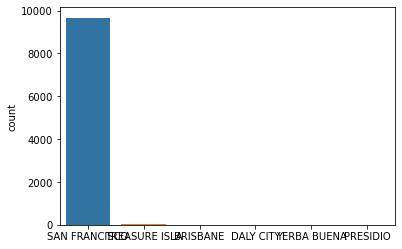

/Users/juandavidescobarescobar/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


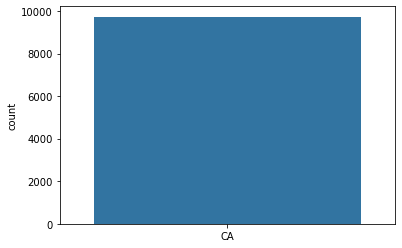

/Users/juandavidescobarescobar/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


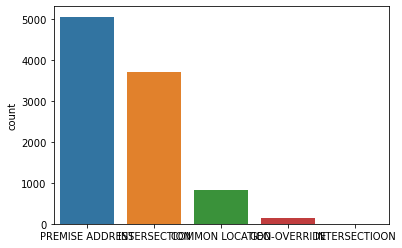

In [68]:
# Validacion de datos atipicos - Variables Categoricas

def draw_hist_cat_vars(list_var_cat):
    
    for col_nm in list_var_cat:
        
        list_data_col = df.select(col_nm)\
                          .rdd.flatMap(lambda x: x)\
                          .collect()
        sns.countplot(list_data_col, )
        plt.show()


list_var_cat = ['OriginalCrimeTypeName','Disposition',\
                'Address','City','State','AddressType']
draw_hist_cat_vars(list_var_cat)

In [70]:
df.filter(f.col("State").isNull()).count()

0

### Tratamiento y validación de Null Values (Variables categóricas)

In [71]:
# grafico histograma para variables categoricas, analiza
# la distribución de los datos

# 1. Conteo de las categorías por variable categorica

def count_categ(df, list_var_cat):
    for col_nm in list_var_cat:
        df.groupby(col_nm).count().show()
    

list_var_cat = ['OriginalCrimeTypeName','Disposition',\
                'Address','City','State','AddressType']

count_categ(df, list_var_cat)

+---------------------+-----+
|OriginalCrimeTypeName|count|
+---------------------+-----+
|                FRAUD|   54|
|                 BAND|    2|
|        WIRELESS-OPEN|    1|
|           THREATS DV|    3|
|              HOLD UP|    1|
|                  800|    6|
|              YELLING|    3|
|             911-DROP|    1|
|            22500F/CW|    1|
|    ASSAULT / BATTERY|  113|
|                  919|   15|
|    PSYCH EVAL / HOLD|    4|
|                 MUNI|    1|
|            FIREWORKS|    1|
|          915 SLEEPER|    1|
|            EXPLOSION|    1|
|           368CA POSS|    1|
|               ATTEMP|    1|
|             POSS/420|    1|
|                UNOCC|    4|
+---------------------+-----+
only showing top 20 rows

+------------+-----+
| Disposition|count|
+------------+-----+
|         ABA|   97|
|         INC|   17|
|          22|   77|
|         NOM|  324|
|         GOA| 1272|
|         CIT| 1406|
|         HAN| 2589|
|         ADM|   46|
|          ND|  423|
| 

In [72]:
df_pd2 = df.toPandas()

list_var_cat = ['OriginalCrimeTypeName','Disposition',\
                'Address','City','State','AddressType']

col_nm = list_var_cat[1]
df_pd2.head()

,CrimeId,OriginalCrimeTypeName,CallDateTime,Disposition,Address,City,State,AgencyId,AddressType
0,160913997,PAY,2016-03-31T23:51:00,ABA,1600 BLOCK OF GREEN ST,SAN FRANCISCO,CA,1,PREMISE ADDRESS
1,160920463,WELL BEING CHECK,2016-04-01T05:49:00,ND,ADA CT/OFARRELL ST,SAN FRANCISCO,CA,1,INTERSECTION
2,160920488,ENCAMPENT,2016-04-01T06:15:00,ADV,500 BLOCK OF FLORIDA ST,SAN FRANCISCO,CA,1,PREMISE ADDRESS
3,160920709,SUSPICIOUS VEHICLE,2016-04-01T08:00:00,HAN,GRANADA AV/HOLLOWAY AV,SAN FRANCISCO,CA,1,INTERSECTION
4,160920723,TRAFFIC STOP,2016-04-01T08:05:00,CIT,7TH ST/MISSION ST,SAN FRANCISCO,CA,1,INTERSECTION


### Tratamiento y validación de valores atipicos

In [73]:
#enables the %%R magic, not necessary if you've already done this
#%%R -i df -w 5 -h 5 --units in -r 200
%load_ext rpy2.ipython

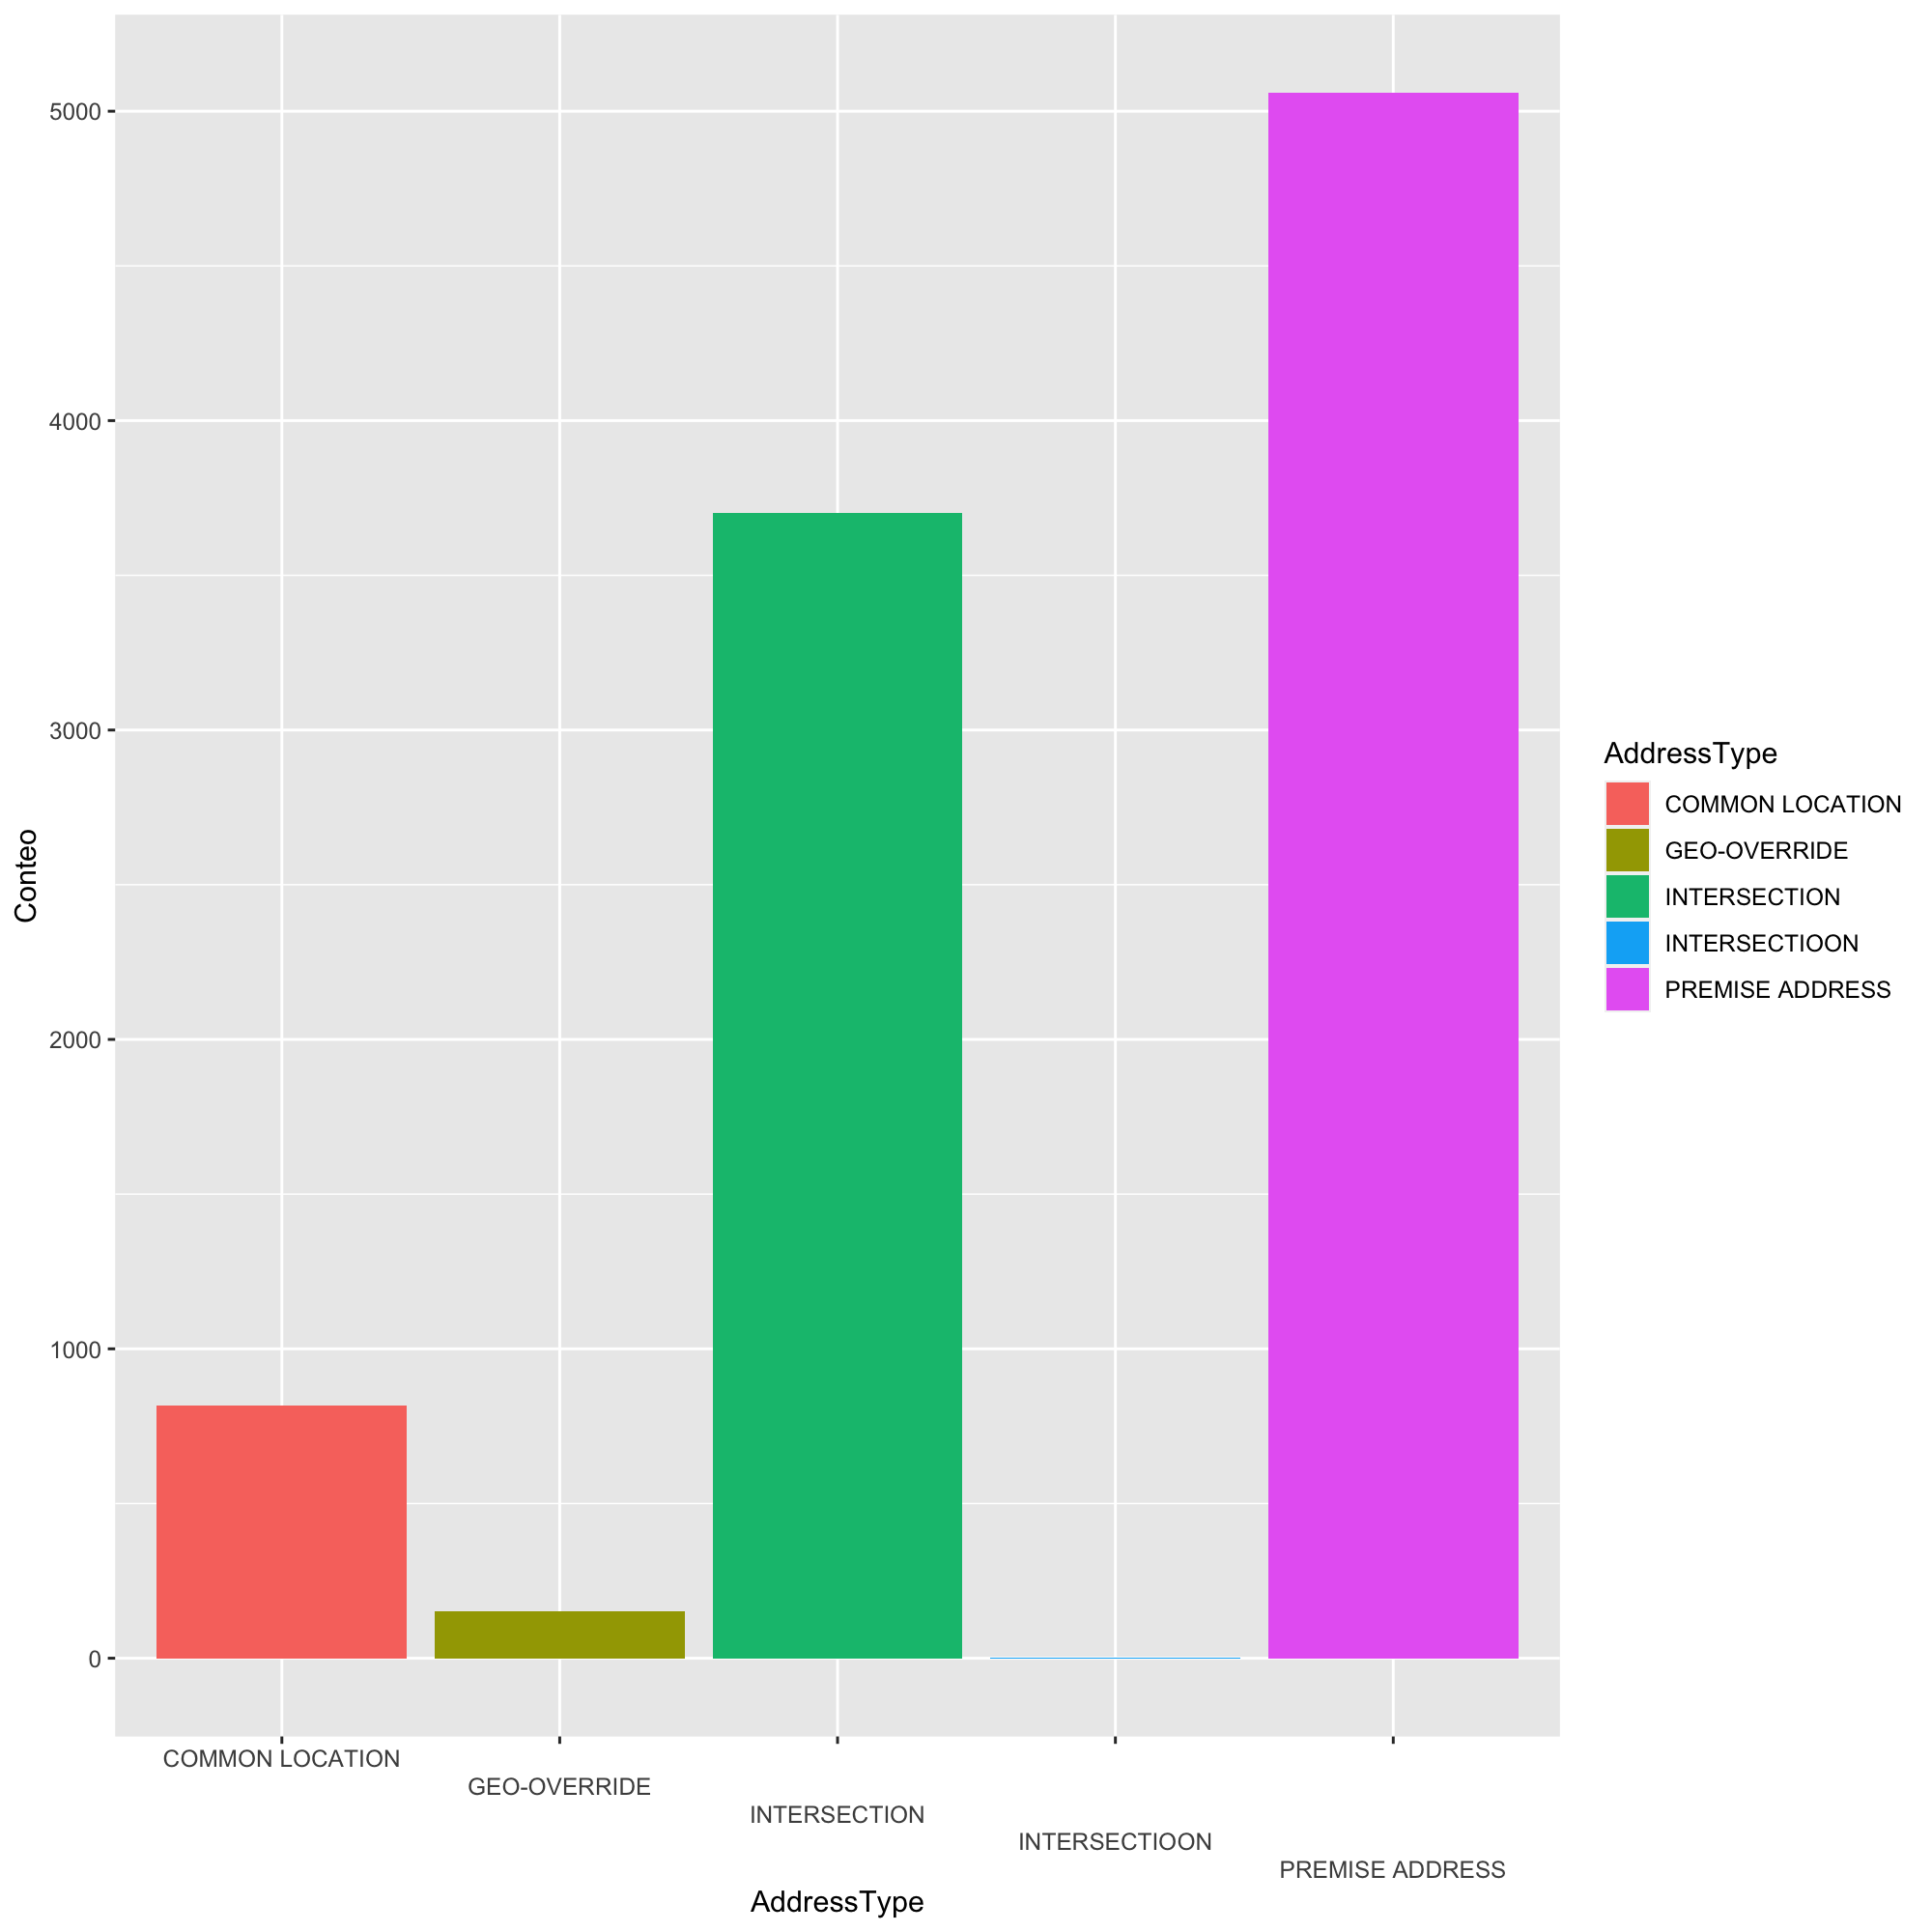

In [74]:
%%R -i df_pd2 -w 10 -h 10 --units in -r 200

install.packages("ggplot2", repos="http://cran.us.r-project.org", quiet=TRUE)
library(ggplot2)

ggplot_result <- ggplot(df_pd2)+
                 geom_bar(aes(x = AddressType, fill = AddressType)) +
                 xlab("AddressType") + ylab("Conteo") +
                 #scale_x_discrete(guide = guide_axis(check.overlap = TRUE))
                 scale_x_discrete(guide = guide_axis(n.dodge=5)) 
                 #theme(axis.text.x = element_text(angle = 30))
ggplot_result

In [75]:
# Eliminar valor atipico 22 por el valor equivalente al 1% de los registos
df = df.filter(f.col("Disposition") != '22')

# Eliminar valores no grabados por el valor equivalente a la media
# df = df.filter(f.col("Disposition") != 'Not recorded')
# df.count()

# Remplazar valores no grabados por el valor  Dummy -99

df = df.withColumn("Disposition", 
      f.when(df["Disposition"] == "Not recorded", -99)
       .otherwise(df["Disposition"]))

In [76]:
# Validación de los datos contenidos en la variable OriginalCrimeTypeName

df_original = df.groupby('OriginalCrimeTypeName').count().orderBy(f.col('count').asc())


#dfa = df_original.filter(f.col('count') == '1')
#dfa.show()

list_ditinct_origin = df_original.select('count')\
                                 .distinct()\
                                 .orderBy(f.col('count').asc()).show()
                               
#Min: 1
#Max: 1194

print(list_ditinct_origin)

+-----+
|count|
+-----+
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
|    9|
|   10|
|   11|
|   12|
|   13|
|   14|
|   15|
|   16|
|   17|
|   18|
|   19|
|   21|
+-----+
only showing top 20 rows

None


In [77]:
# Eliminación registros que continenen valores númericos en
# la variable OriginalCrimeTypeName

df.count()
#9156

df = df.filter(~f.col("OriginalCrimeTypeName").cast("int").isNotNull())
df.count()
#9631

9233

In [78]:
# Remplazar valor atipico o incongruente de la variable City = 'S'
 
df = df.withColumn("City", 
      f.when(df["City"] == "S", "SAN FRANCISCO")
       .otherwise(df["Disposition"]))

In [79]:
# Remplazar valor atipico o incongruente de la variable AddressType = '1'
 
df = df.withColumn("AddressType", 
      f.when(df["AddressType"] == "1", "-99")
       .otherwise(df["AddressType"]))

In [80]:
# Remplazar valor atipico o incongruente de la variable State = 'NA'
 
df = df.withColumn("State", 
      f.when(df["AgencyId"] == "CA", "CA")
       .otherwise(df["AgencyId"])) 

In [81]:
# Remplazar valor atipico o incongruente de la variable AgencyId = 'CA'
 
df = df.withColumn("AgencyId", 
      f.when(df["AgencyId"] == "CA", 1)
       .otherwise(df["AgencyId"]))

In [82]:
df.describe()

DataFrame[summary: string, CrimeId: string, OriginalCrimeTypeName: string, CallDateTime: string, Disposition: string, Address: string, City: string, State: string, AgencyId: string, AddressType: string]

## Fase 3. Datos resultados (Result Zone)

In [83]:
# Ajustar esquema de acuerdo a la naturaleza de los datos analizados en el Datset

df2 = df.withColumn("CallDateTime", f.col("CallDateTime").cast(TimestampType()))\
        .withColumn("AgencyId", f.col("AgencyId").cast(IntegerType()))

df2.describe()
#df2.show()

DataFrame[summary: string, CrimeId: string, OriginalCrimeTypeName: string, Disposition: string, Address: string, City: string, State: string, AgencyId: string, AddressType: string]

In [84]:
# Ajustar esquema de acuerdo a la naturaleza de los datos analizados en el Datset

# StructField("Range", StringType(), True),  \ # col eliminada
# StructField("OffenseDate", StringType(), True),  \ # col eliminada
# StructField("CallTime", StringType(), True),  \ # col eliminada

schema = StructType([ \
    StructField("CrimeId",IntegerType(),False), \
    StructField("OriginalCrimeTypeName",StringType(),True), \
    StructField("CallDateTime", TimestampType(), True), \
    StructField("Disposition", StringType(), True), \
    StructField("Address", StringType(), True), \
    StructField("City", StringType(), True), \
    StructField("State", StringType(), True), \
    StructField("AgencyId", IntegerType(), True), \
    StructField("AddressType", StringType(), True)  \
  ])

df_result = spark.createDataFrame(data = df2.collect(), schema = schema)
df_result.printSchema()
df_result.show()

root
 |-- CrimeId: integer (nullable = false)
 |-- OriginalCrimeTypeName: string (nullable = true)
 |-- CallDateTime: timestamp (nullable = true)
 |-- Disposition: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- AgencyId: integer (nullable = true)
 |-- AddressType: string (nullable = true)

+---------+---------------------+-------------------+------------+--------------------+------------+-----+--------+---------------+
|  CrimeId|OriginalCrimeTypeName|       CallDateTime| Disposition|             Address|        City|State|AgencyId|    AddressType|
+---------+---------------------+-------------------+------------+--------------------+------------+-----+--------+---------------+
|160913997|                  PAY|2016-03-31 23:51:00|         ABA|1600 BLOCK OF GRE...|         ABA|    1|       1|PREMISE ADDRESS|
|160920463|     WELL BEING CHECK|2016-04-01 05:49:00|          ND|  ADA CT/OFARRELL ST

### Analisis de correlación entre las variables númericas

In [ ]:
import numpy as np; np.random.seed(1)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a random dataset
df_correl = df_result.select('CrimeId', 'AgencyId').toPandas()

# Compute the correlation matrix
corr = df_correl.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Draw the heatmap with the mask and correct aspect ratio
vmax = np.abs(corr.values[~mask]).max()
sns.heatmap(corr, mask=mask, cmap=plt.cm.PuOr, vmin=-vmax, vmax=vmax,
            square=True, linecolor="lightgray", linewidths=1, ax=ax)
for i in range(len(corr)):
    ax.text(i+0.5,len(corr)-(i+0.5), corr.columns[i], 
            ha="center", va="center", rotation=45)
    for j in range(i+1, len(corr)):
        s = "{:.3f}".format(corr.values[i,j])
        ax.text(j+0.5,len(corr)-(i+0.5),s, 
            ha="center", va="center")
ax.axis("off")
plt.show()

{'colorbar.N': 100, 'colorbar.shrink': 0.8, 'colorbar.orientation': 'vertical'}


/Users/juandavidescobarescobar/opt/anaconda3/lib/python3.9/site-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(D, method=method, metric=metric)


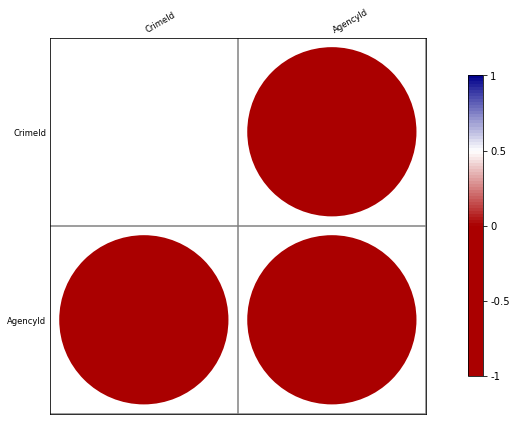

In [85]:
import pandas
import numpy
from pyensae.graphhelper import Corrplot

df_correl = df_result.select('CrimeId', 'AgencyId').toPandas()

c = Corrplot(df_correl)

print(c.params)
c.plot(figsize=(12,6))
plt.show()

In [86]:
df_result.head()

Row(CrimeId=160913997, OriginalCrimeTypeName='PAY', CallDateTime=datetime.datetime(2016, 3, 31, 23, 51), Disposition='ABA', Address='1600 BLOCK OF GREEN ST', City='ABA', State='1', AgencyId=1, AddressType='PREMISE ADDRESS')

### Converción de Dataframe a formato JSON

In [87]:
# Crear JSON-Result
import json

df_json = df_result.limit(2).toJSON()

for row in df_json.collect():
    #json string
    print(row, '\n') 
    
    
def print_rows(row):
    data = json.loads(row)
     
    for key in data:
        print("{key}:{value}".format(key=key, value=data[key])) 

    print('\n')  

df_json.foreach(print_rows)  

{"CrimeId":160913997,"OriginalCrimeTypeName":"PAY","CallDateTime":"2016-03-31T23:51:00.000-05:00","Disposition":"ABA","Address":"1600 BLOCK OF GREEN ST","City":"ABA","State":"1","AgencyId":1,"AddressType":"PREMISE ADDRESS"} 

{"CrimeId":160920463,"OriginalCrimeTypeName":"WELL BEING CHECK","CallDateTime":"2016-04-01T05:49:00.000-05:00","Disposition":"ND","Address":"ADA CT/OFARRELL ST","City":"ND","State":"1","AgencyId":1,"AddressType":"INTERSECTION"} 



CrimeId:160913997
OriginalCrimeTypeName:PAY
CallDateTime:2016-03-31T23:51:00.000-05:00
Disposition:ABA
Address:1600 BLOCK OF GREEN ST
City:ABA
State:1
AgencyId:1
AddressType:PREMISE ADDRESS


CrimeId:160920463
OriginalCrimeTypeName:WELL BEING CHECK
CallDateTime:2016-04-01T05:49:00.000-05:00
Disposition:ND
Address:ADA CT/OFARRELL ST
City:ND
State:1
AgencyId:1
AddressType:INTERSECTION




In [24]:
list_result = [  
{
    "_id": 1,
    "CrimeId": 160913997,
    "OriginalCrimeTypeName": "Pay",
    "CallDateTime": "2016-03-31T23:51:00.000-05:00",
    "Disposition": "ABA",
    "Address": "1600 Block Of Green St",
    "City": "ABA",
    "State": "1",
    "Agency": {
        "_id": 1
    },
    "AddressType": "Premise Address"
},
{
    "_id": 2,
    "CrimeId": 160920463,
    "OriginalCrimeTypeName": "Well Being Check",
    "CallDateTime": "2016-04-01T05:49:00.000-05:00",
    "Disposition": "ND",
    "Address": "Ada Ct/ofarrell St",
    "City": "ND",
    "State": "1",
    "Agency": {
        "_id": 1
    },
    "AddressType": "Intersection"
}
]

print(list_result)

[{'_id': 1, 'CrimeId': 160913997, 'OriginalCrimeTypeName': 'Pay', 'CallDateTime': '2016-03-31T23:51:00.000-05:00', 'Disposition': 'ABA', 'Address': '1600 Block Of Green St', 'City': 'ABA', 'State': '1', 'Agency': {'_id': 1}, 'AddressType': 'Premise Address'}, {'_id': 2, 'CrimeId': 160920463, 'OriginalCrimeTypeName': 'Well Being Check', 'CallDateTime': '2016-04-01T05:49:00.000-05:00', 'Disposition': 'ND', 'Address': 'Ada Ct/ofarrell St', 'City': 'ND', 'State': '1', 'Agency': {'_id': 1}, 'AddressType': 'Intersection'}]


### Almacenar nuevo Dataset en fuente de datos destino (MongoDB)

In [1]:
import pip
pip.main(['install', 'pymongo'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [22]:
import pymongo
from pymongo import MongoClient

#client = MongoClient('localhost', 27017)
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['crimesdb']

print(db)

my_collect = db["crimenes"]

print(my_collect)

collist = db.list_collection_names()

print(db.list_collection_names())

if "crimenes" in collist:

    print("The collection exists.")

    results = collection.insert_many(dic_result)
    print ("Insert a many documents: inserted ids: " + str(results.inserted_ids) + ", acknowledged: " + str(results.acknowledged))

    x = my_collect.insert_many(dic_result)
    print(x.inserted_ids)

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'crimesdb')
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'crimesdb'), 'crimenes')
[]


In [30]:
# Select all values from CrimesDB
import json
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["crimesdb"]
mycol = mydb["crimenes"]

print(mycol.find())

for x in mycol.find():
    print(x)       

{'_id': 1, 'CrimeId': 160913997, 'OriginalCrimeTypeName': 'Pay', 'CallDateTime': '2016-03-31T23:51:00.000-05:00', 'Disposition': 'ABA', 'Address': '1600 Block Of Green St', 'City': 'ABA', 'State': '1', 'Agency': {'_id': 1}, 'AddressType': 'Premise Address'}
{'_id': 2, 'CrimeId': 160920463, 'OriginalCrimeTypeName': 'Well Being Check', 'CallDateTime': '2016-04-01T05:49:00.000-05:00', 'Disposition': 'ND', 'Address': 'Ada Ct/ofarrell St', 'City': 'ND', 'State': '1', 'Agency': {'_id': 1}, 'AddressType': 'Intersection'}


In [31]:
import pip
pip.main(['install', 'nbconvert'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [34]:
%%bash
jupyter nbconvert --to webpdf --allow-chromium-download "Limpieza Datos Dataset - CSV.ipynb"

[NbConvertApp] Converting notebook Limpieza Datos Dataset - CSV.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 623951 bytes to Limpieza Datos Dataset - CSV.pdf


In [ ]:
sc.stop()

# 4. Limpieza Específica

In [ ]:
# '''
# # 3. Filas leidas

# df.count()
# # 10051

In [ ]:
# '''
# # 4. Columnas leidas

# len(df.columns)
# # 12

In [ ]:
# '''
# # 5. Limpieza general - Datos perdidos N/A or None (Elimina las filas duplicadas - por todos los campos)

# #df.dropna()
# display(HTML("<style>pre { white-space: pre !important; }</style>"))
# df.dropna(how='all').show()
# df.count()

In [ ]:
# '''
# # 6. Limpieza general - Borrar columnas con None / NAN 

# df = df.toPandas().dropna(axis=1, how='all')
# len(df.columns)

In [ ]:
# '''
# # 7. Limpieza general - Elimina las filas duplicadas - por todos los campos

# df = df.drop_duplicates()
# df.count()

In [ ]:
# '''
# # 8. Limpieza general - Elimina las filas duplicadas - por "CrimeId"

# df_pk = 'CrimeId'
# result_duplicates = get_duplicates(df, df_pk)

# if result_duplicates['is_error']:
#     df.drop_duplicates(subset = [df_pk])
#     print('Identificadores duplicados: {0}'.format(result_duplicates['is_error']))

In [ ]:
# '''
# # 1. Ajustar esquema de acuerdo a la naturaleza de los datos analizados en el Datset
# #StructField("Range", StringType(), True),  \ # col eliminada


# schema = StructType([ \
#     StructField("CrimeId",IntegerType(),False), \
#     StructField("OriginalCrimeTypeName",StringType(),True), \
#     StructField("OffenseDate",TimestampType(),True), \
#     StructField("CallTime", StringType(), True), \
#     StructField("CallDateTime", TimestampType(), True), \
#     StructField("Disposition", StringType(), True), \
#     StructField("Address", StringType(), True), \
#     StructField("City", StringType(), True), \
#     StructField("State", StringType(), True), \
#     StructField("AgencyId", IntegerType(), True), \
#     StructField("AddressType", StringType(), True)  \
#   ])

# data = df.values.tolist()
# df = spark.createDataFrame(data = data)


# df_new = spark.createDataFrame(data = df.rdd, schema = schema)
# df_new.printSchema()
# df_new.show()

In [ ]:
# '''
# display(df_new)

In [ ]:
# '''
# # 1. Validar el porcentaje de correlación de los datos

# # df2.stat.corr('CrimeId', 'CallTime')

In [ ]:
# '''
# # 2. Validar la variable media y desviacion estandar para los tipos de datos númericos

In [ ]:
# '''
# df_pd = df_pd.fillna(df_pd.mean())

# df_pd.info()

# df_pd['Range']

In [ ]:
# '''
# #display(HTML("<style>pre { white-space: pre !important; }</style>"))
# #df.show()
# df.limit(20).toPandas().head()
# df.printSchema()

# #len(df.columns)
# df.limit(20).toPandas().head()
# '''

In [ ]:
# '''
# |-- CrimeId: integer (nullable = true)
# |-- OriginalCrimeTypeName: string (nullable = true)
# |-- OffenseDate: timestamp (nullable = true)  YYYY-MM-DD T HH:MM:SS
# |-- CallTime: string (nullable = true) HH:MM
# |-- CallDateTime: timestamp (nullable = true) YYYY-MM-DD T HH:MM:SS
# |-- Disposition: string (nullable = true) 3 charascter MAX EX: REP
# |-- Address: string (nullable = true) 
# |-- City: string (nullable = true)
# |-- State: string (nullable = true) CA 2 CHARACTERS
# |-- AgencyId: string (nullable = true) INT (OJO ERROR)
# |-- Range: string (nullable = true) INT?? OJO SIN DATOS
# |-- AddressType: string (nullable = true) String
# '''

In [ ]:
# '''
# df2.describe('CrimeId', 'OriginalCrimeTypeName').show()
# df2.describe('OffenseDate', 'CallTime').show()
# '''

In [ ]:
# '''
# # Almacenar la informacion del DF en una tabla temporal para poder manipularlo mediante consultas

# temp_table_csv_name = 'crimes'

# df.createOrReplaceTempView(temp_table_csv_name)
# df2 = spark.sql('SELECT * FROM ' + temp_table_csv_name)
# df2.limit(20).toPandas().head()
# df2.cache()
# '''

In [ ]:
# '''
# Describe de los valores enteros, para validar los numeros:
# MAX, MIN, COUNT, MEAN (PROMEDIO) Y LA 
# DESVIACION ESTANDAR

# X   |X - (~X)         | (X - (~X))^2

# 5   |5 - 15,6 = -10,6 | (-10,6)^2 = 112,36
# 15  |-0,6             | 0,36
# 12  |-3,6             | 12,96
# 18  |2,4              | 5,76
# 28  |12,4             | 153,76
#                         (285,2)        

# ~X = 5 +15 + 12 +18 + 28 / 5 = 15,6

# s = raiz(sum( (X - (~X))^2 ) / N-1)
# s = raiz(285,1 / (5-1)) = 8,44


# La desviacion estandar me indica la variacion que existe en los datos de la muestra,
# es decir que tan diferentes o parecidos son.



# import matplotlib.pyplot as plt
# import numpy as np

# x = np.array([5, 15, 12, 18, 28])
# y = np.power(x, 2) # Effectively y = x**2

# plt.errorbar(x, y, linestyle='None', marker='x')

# plt.show()

# '''

In [ ]:
# '''
# --------------------------------------------------------------------------------------------
# 0. Contar filas
# 0. Contar columnas
# --------------------------------------------------------------------------------------------
# Limpieza de datos:

# 1. Datos perdidos N/A or None       

# Encontrar Nulos
# df.isnull()

# Filtrar datos perdidos
# from numpy import nan as NA
# df.dropna()

# Borrar filas que todos los registros sean None / NA
# df.dropna(how='all')

# Borrar columnas con None / NA
# df.dropna(axis=1, how='all')

# Borrar ciertos NA, es decir solo lo que le indiquemos
# df.dropna(thresh=2)

# Rellenar datos con un valor predeterminado
# df.fillna(0)

# Rellenar datos con un valor de un key de un dic
# para la col 1 y 2
# df.fillna({1:0.5, 2:5})

# df.fillna(method='ffill') #fordward fill, rellena con el ultimo valor que no era NA
# df.fillna(method='ffill', limit=1) #lo mismo pero solo para un NAN

# df.fillna(data.mean()) #rellena con un promedio de los valores de la fila y no con 0

# --------------------------------------------------------------------------------------------
# 2. Datos duplicados

# Nos dice las filas que estan duplicadas

# df.duplicated()

# Elimina las filas duplicadas

# df.drop_duplicates()


# 3. Manipulación de strings
# 4. Transformación de datos

# '''

In [ ]:
# '''
# df_disposition_count = df.groupby('Disposition').count()
# df_disposition_media = df_disposition_count.withColumn('count_media', f.expr("approx_percentile(count, 0.5, 10) over ()"))

# df_grp_mean = df_disposition_count.groupBy('Disposition')\
#                                   .agg(f.mean(df_disposition_count['count'])\
#                                   .alias('mean_val'))
# df_grp_mean.show()
# '''

In [ ]:
# '''
# # Remplazar valores no grabados por el valor equivalente a la media
# df = df.withColumn("Disposition", 
#       f.when(df[update_col] == "Not recorded", "")
#        .otherwise(df["Disposition"]))
# '''       

In [10]:
# from pymongo import MongoClient

# if __name__ == '__main__':
#     client = MongoClient("mongodb://localhost:27017/")

#     with client.start_session(causal_consistency = True) as my_session:
#         with my_session.start_transaction():

#             db = client.mydb
#             collection = db.mycollection
            
#             print(db)

#             # GET THE COUNT OF DOCUMENTS
#             count = collection.count_documents({"firstname": "John"})
#             print ("count of documents: " + str(count))

#             # ITERATE A QUERY
#             for result in collection.find({"firstname": "John"}):
#                 print ("Iterate a query: " + str(result))

#             # INSERT A SINGLE DOCUMENT
#             results = collection.insert_one({"firstname": "John"}, session = my_session)
#             print ("Insert a single document: inserted id: " + str(results.inserted_id) + ", acknowledged: " + str(results.acknowledged))

#             # INSERT MANY DOCUMENTS (INCLUDE A FIELD CALLED 'number' WITH A RANGE FROM 0 TO 4)
#             results = collection.insert_many([{"firstname": "John", "number": i} for i in range(5)], session = my_session)
#             print ("Insert a many documents: inserted ids: " + str(results.inserted_ids) + ", acknowledged: " + str(results.acknowledged))

#             # UPDATE ONE (TACK ON ANOTHER FIELD CALLED 'lastname')
#             results = collection.update_one({"number": 1}, {"$set": {"lastname": "Doe"}}, session = my_session)
#             print ("Update one: acknowledged: " + str(results.acknowledged) + ", matched_count: " + str(results.matched_count) + ", modified_count: " + str(results.modified_count) + ", upserted_id: " + str(results.upserted_id) + ", raw_result: " + str(results.raw_result))

#             # UPSERT ONE (THIS WILL CREATE A DOCUMENT WITH FIELD CALLED 'number' WITH A VALUE OF 23 ALONG WITH FIRST AND LAST NAME FIELDS.
#             results = collection.update_one({"number": 23}, {"$set": {"firstname": "John", "lastname": "Doe"}}, True, session = my_session)
#             print ("Upsert one: acknowledged: " + str(results.acknowledged) + ", matched_count: " + str(results.matched_count) + ", modified_count: " + str(results.modified_count) + ", upserted_id: " + str(results.upserted_id) + ", raw_result: " + str(results.raw_result))

#             # UPDATE MANY
#             results = collection.update_many({"firstname": "John"}, {"$set": {"city": "Newark"}}, session = my_session)
#             print ("Update many: acknowledged: " + str(results.acknowledged) + ", matched_count: " + str(results.matched_count) + ", modified_count: " + str(results.modified_count) + ", upserted_id: " + str(results.upserted_id) + ", raw_result: " + str(results.raw_result))

#             # UPSERT MANY (THIS WILL ONLY INSERT ONE RECORD IF FILTER NOT FOUND, BUT COULD UPDATE MANY)
#             results = collection.update_many({"firstname": "John", "middlename": "Jacob"}, {"$set": {"city": "Newark", "state": "Ohio", "number": i} for i in range(5)}, upsert = True, session = my_session)
#             print ("Upsert many: acknowledged: " + str(results.acknowledged) + ", matched_count: " + str(results.matched_count) + ", modified_count: " + str(results.modified_count) + ", upserted_id: " + str(results.upserted_id) + ", raw_result: " + str(results.raw_result))

#             # DELETE MANY
#             results = collection.delete_many({"firstname": "John"}, session = my_session)

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'mydb')
